# Image Caption Generator with Pytorch 🖼️✨  


This project creates a system that looks at an image and automatically generates a caption that describes it. Think of it as teaching a computer to "see" and "speak" at the same time!  

### What You'll Learn:  
- How computers process images and text.  
- How to build and train a model that generates captions for images.  
- How to evaluate the quality of the captions.  

---

### **What is Image Captioning?**  
```markdown

Image captioning is the process of generating a natural language description for an image.  

Use cases 
- Helps visually impaired people understand images.  
- Automatically tags images for e-commerce or social media.  
- Automation: Saves time for manual tasks like labeling or writing descriptions.  


## The Dataset  

This model was trained on **COCO Dataset** (Common Objects in Context), which consists of over 200,000 labeled images with five captions for each image. Since it's advent in 2014 it has helped significantly in object recognition related tasks. 




## How It Works  

We use Pytorch to train a CNN-LSTM model to generate captions for unseen images.
This system has two parts:  
1. **Image Understanding (Encoder)**:  
   - A computer "looks" at the image and extracts key features using a pre-trained model (ResNet).  

2. **Caption Generation (Decoder)**:  
   - These features are passed to a language model (LSTM) to generate a caption word by word.  

Imagine this process as taking a photo and describing it aloud. The encoder is like your brain recognizing objects, and the decoder is like forming sentences to describe what you see.  


# Importing dependencies

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence
from PIL import Image
import os
import pickle
import nltk
from pycocotools.coco import COCO
from collections import Counter
import torch.utils.data as data
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import random_split, Dataloader

# Downloading Images and their respective annotations

In [2]:
!apt-get install wget

# create a data directory
!mkdir data_dir

# download images and annotations to the data directory
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip -P ./data_dir/
!wget http://images.cocodataset.org/zips/train2014.zip -P ./data_dir/
!wget http://images.cocodataset.org/zips/val2014.zip -P ./data_dir/

# extract zipped images and annotations and remove the zip files
!unzip ./data_dir/annotations_trainval2014.zip -d ./data_dir/
!rm ./data_dir/annotations_trainval2014.zip
!unzip ./data_dir/train2014.zip -d ./data_dir/
!rm ./data_dir/train2014.zip
!unzip ./data_dir/val2014.zip -d ./data_dir/
!rm ./data_dir/val2014.zip

Streaming output truncated to the last 5000 lines.
 extracting: ./data_dir/val2014/COCO_val2014_000000535608.jpg  
 extracting: ./data_dir/val2014/COCO_val2014_000000279145.jpg  
 extracting: ./data_dir/val2014/COCO_val2014_000000243495.jpg  
 extracting: ./data_dir/val2014/COCO_val2014_000000225791.jpg  
 extracting: ./data_dir/val2014/COCO_val2014_000000428067.jpg  
 extracting: ./data_dir/val2014/COCO_val2014_000000059383.jpg  
 extracting: ./data_dir/val2014/COCO_val2014_000000558498.jpg  
 extracting: ./data_dir/val2014/COCO_val2014_000000376123.jpg  
 extracting: ./data_dir/val2014/COCO_val2014_000000191304.jpg  
 extracting: ./data_dir/val2014/COCO_val2014_000000171062.jpg  
 extracting: ./data_dir/val2014/COCO_val2014_000000014549.jpg  
 extracting: ./data_dir/val2014/COCO_val2014_000000121152.jpg  
 extracting: ./data_dir/val2014/COCO_val2014_000000276596.jpg  
 extracting: ./data_dir/val2014/COCO_val2014_000000029431.jpg  
 extracting: ./data_dir/val2014/COCO_val2014_00000003

# Processing the caption (text) data

We download a dataset to tokenize out texts from the Natural laguage toolkit library. We will use NLTK to build our vocabulary for the texts.

In [3]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

Now we build our vocabulary => that is a dictionary that can convert words into numerical tokens.

In [9]:
class Vocab(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.w2i = {}
        self.i2w = {}
        self.index = 0

    def __call__(self, token):
        if not token in self.w2i:
            return self.w2i['<unk>']
        return self.w2i[token]

    def __len__(self):
        return len(self.w2i)
    def add_token(self, token):
        if not token in self.w2i:
            self.w2i[token] = self.index
            self.i2w[self.index] = token
            self.index += 1

def build_vocabulary(json, threshold):
    """Build a simple vocabulary wrapper."""
    coco = COCO(json)
    counter = Counter()
    ids = coco.anns.keys()
    for i, id in enumerate(ids):
        caption = str(coco.anns[id]['caption'])
        tokens = nltk.tokenize.word_tokenize(caption.lower())
        counter.update(tokens)

        if (i+1) % 1000 == 0:
            print("[{}/{}] Tokenized the captions.".format(i+1, len(ids)))

    # If the word frequency is less than 'threshold', then the word is discarded.
    tokens = [token for token, cnt in counter.items() if cnt >= threshold]

    # Create a vocab wrapper and add some special tokens.
    vocab = Vocab()
    vocab.add_token('<pad>')
    vocab.add_token('<start>')
    vocab.add_token('<end>')
    vocab.add_token('<unk>')

    # Add the words to the vocabulary.
    for i, token in enumerate(tokens):
        vocab.add_token(token)
    return vocab

vocab = build_vocabulary(json='data_dir/annotations/captions_train2014.json', threshold=4)
vocab_path = './data_dir/vocabulary.pkl'
with open(vocab_path, 'wb') as f:
    pickle.dump(vocab, f)
print("Total vocabulary size: {}".format(len(vocab)))
print("Saved the vocabulary wrapper to '{}'".format(vocab_path))

loading annotations into memory...
Done (t=0.99s)
creating index...
index created!
[1000/414113] Tokenized the captions.
[2000/414113] Tokenized the captions.
[3000/414113] Tokenized the captions.
[4000/414113] Tokenized the captions.
[5000/414113] Tokenized the captions.
[6000/414113] Tokenized the captions.
[7000/414113] Tokenized the captions.
[8000/414113] Tokenized the captions.
[9000/414113] Tokenized the captions.
[10000/414113] Tokenized the captions.
[11000/414113] Tokenized the captions.
[12000/414113] Tokenized the captions.
[13000/414113] Tokenized the captions.
[14000/414113] Tokenized the captions.
[15000/414113] Tokenized the captions.
[16000/414113] Tokenized the captions.
[17000/414113] Tokenized the captions.
[18000/414113] Tokenized the captions.
[19000/414113] Tokenized the captions.
[20000/414113] Tokenized the captions.
[21000/414113] Tokenized the captions.
[22000/414113] Tokenized the captions.
[23000/414113] Tokenized the captions.
[24000/414113] Tokenized the 

# Resize Images
Images can come in different sizes and dimension, now we have to reshape all images that will be passed into the first layer of our CNN model. 
We use image shape of 256 x 256.


In [5]:
def reshape_image(image, shape):
    """Resize an image to the given shape."""
    return image.resize(shape, Image.LANCZOS)

def reshape_images(image_path, output_path, shape):
    """Reshape the images in 'image_path' and save into 'output_path'."""
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    images = os.listdir(image_path)
    num_im = len(images)
    for i, im in enumerate(images):
        with open(os.path.join(image_path, im), 'r+b') as f:
            with Image.open(f) as image:
                image = reshape_image(image, shape)
                image.save(os.path.join(output_path, im), image.format)
        if (i+1) % 100 == 0:
            print ("[{}/{}] Resized the images and saved into '{}'."
                   .format(i+1, num_im, output_path))

image_path = './data_dir/train2014/'
output_path = './data_dir/resized_images/'
image_shape = [256, 256]
reshape_images(image_path, output_path, image_shape)

[100/82783] Resized the images and saved into './data_dir/resized_images/'.
[200/82783] Resized the images and saved into './data_dir/resized_images/'.
[300/82783] Resized the images and saved into './data_dir/resized_images/'.
[400/82783] Resized the images and saved into './data_dir/resized_images/'.
[500/82783] Resized the images and saved into './data_dir/resized_images/'.
[600/82783] Resized the images and saved into './data_dir/resized_images/'.
[700/82783] Resized the images and saved into './data_dir/resized_images/'.
[800/82783] Resized the images and saved into './data_dir/resized_images/'.
[900/82783] Resized the images and saved into './data_dir/resized_images/'.
[1000/82783] Resized the images and saved into './data_dir/resized_images/'.
[1100/82783] Resized the images and saved into './data_dir/resized_images/'.
[1200/82783] Resized the images and saved into './data_dir/resized_images/'.
[1300/82783] Resized the images and saved into './data_dir/resized_images/'.
[1400/82

# Instantiate data loader.
We are done with downloading and preprocessing our image captioning data. We will now cast this data into a PyTorch dataset object.

In [10]:
class CustomCocoDataset(data.Dataset):
    """COCO Custom Dataset compatible with torch.utils.data.DataLoader."""
    def __init__(self, data_path, coco_json_path, vocabulary, transform=None, subsample_size= None):
        """Set the path for images, captions and vocabulary wrapper.

        Args:
            root: image directory.
            json: coco annotation file path.
            vocab: vocabulary wrapper.
            transform: image transformer.
        """
        self.root = data_path
        self.coco_data = COCO(coco_json_path)
        self.indices = list(self.coco_data.anns.keys())
        if subsample_size :
          self.indices = self.indices[:subsample_size]
        self.vocabulary = vocabulary
        self.transform = transform

    def __getitem__(self, idx):
        """Returns one data pair (image and caption)."""
        coco_data = self.coco_data
        vocabulary = self.vocabulary
        annotation_id = self.indices[idx]
        caption = coco_data.anns[annotation_id]['caption']
        image_id = coco_data.anns[annotation_id]['image_id']
        image_path = coco_data.loadImgs(image_id)[0]['file_name']

        image = Image.open(os.path.join(self.root, image_path)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        # Convert caption (string) to word ids.
        word_tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption = []
        caption.append(vocabulary('<start>'))
        caption.extend([vocabulary(token) for token in word_tokens])
        caption.append(vocabulary('<end>'))
        ground_truth = torch.Tensor(caption)
        return image, ground_truth

    def __len__(self):
        return len(self.indices)


def collate_function(data_batch):
    """Creates mini-batch tensors from the list of tuples (image, caption).

    We should build custom collate_fn rather than using default collate_fn,
    because merging caption (including padding) is not supported in default.
    Args:
        data: list of tuple (image, caption).
            - image: torch tensor of shape (3, 256, 256).
            - caption: torch tensor of shape (?); variable length.
    Returns:
        images: torch tensor of shape (batch_size, 3, 256, 256).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    # Sort a data list by caption length (descending order).
    data_batch.sort(key=lambda d: len(d[1]), reverse=True)
    images, capts = zip(*data_batch)

    # Merge images (from list of 3D tensors to 4D tensor).
    # Originally, images is a list of <batch_size> number of RGB images with dimensions (3, 256, 256)
    # This line of code turns it into a single tensor of dimensions (<batch_size>, 3, 256, 256)
    images = torch.stack(images, 0)

    # Merge captions (from list of 1D tensors to 2D tensor), similar to merging of images donw above.
    cap_lens = [len(cap) for cap in capts]
    targets = torch.zeros(len(capts), max(cap_lens)).long()
    for i, cap in enumerate(capts):
        end = cap_lens[i]
        targets[i, :end] = cap[:end]
    return images, targets, cap_lens

def get_loader(data_path, coco_json_path, vocabulary, transform, batch_size, shuffle):
    """Returns torch.utils.data.DataLoader for custom coco dataset."""
    # COCO caption dataset
    coco_dataser = CustomCocoDataset(data_path=data_path,
                       coco_json_path=coco_json_path,
                       vocabulary=vocabulary,
                       transform=transform)

    # Data loader for COCO dataset
    # This will return (images, captions, lengths) for each iteration.
    # images: a tensor of shape (batch_size, 3, 224, 224).
    # captions: a tensor of shape (batch_size, padded_length).
    # lengths: a list indicating valid length for each caption. length is (batch_size).
    custom_data_loader = torch.utils.data.DataLoader(dataset=coco_dataser,
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              collate_fn=collate_function)
    return custom_data_loader

# Defining the CNN-LSTM model
We use resnet34 architecture from the Pytorch models repository


In [11]:
class CNNModel(nn.Module):
    def __init__(self, embedding_size):
        """Load the pretrained ResNet-34 and replace top fully connected layer."""
        super(CNNModel, self).__init__()
        resnet = models.resnet34(weights=True)
        module_list = list(resnet.children())[:-1]# delete the last fc layer.
        self.resnet_module = nn.Sequential(*module_list)
        self.linear_layer = nn.Linear(resnet.fc.in_features, embedding_size)
        self.batch_norm = nn.BatchNorm1d(embedding_size, momentum=0.01)

    def forward(self, input_images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            resnet_features = self.resnet_module(input_images)
        resnet_features = resnet_features.reshape(resnet_features.size(0), -1)
        final_features = self.batch_norm(self.linear_layer(resnet_features))
        return final_features


class LSTMModel(nn.Module):
    def __init__(self, embedding_size, hidden_layer_size, vocabulary_size, num_layers, max_seq_len=20):
        """Set the hyper-parameters and build the layers."""
        super(LSTMModel, self).__init__()
        self.embedding_layer = nn.Embedding(vocabulary_size, embedding_size)
        self.lstm_layer = nn.LSTM(embedding_size, hidden_layer_size, num_layers, batch_first=True)
        self.linear_layer = nn.Linear(hidden_layer_size, vocabulary_size)
        self.max_seq_len = max_seq_len

    def forward(self, input_features, capts, lens):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embedding_layer(capts)
        embeddings = torch.cat((input_features.unsqueeze(1), embeddings), 1)
        lstm_input = pack_padded_sequence(embeddings, lens, batch_first=True)
        hidden_variables, _ = self.lstm_layer(lstm_input)
        model_outputs = self.linear_layer(hidden_variables[0])
        return model_outputs

    def sample(self, input_features, lstm_states=None):
        """Generate captions for given image features using greedy search."""
        sampled_indices = []
        lstm_inputs = input_features.unsqueeze(1)
        for i in range(self.max_seq_len):
            hidden_variables, lstm_states = self.lstm_layer(lstm_inputs, lstm_states)# hiddens: (batch_size, 1, hidden_size)
            model_outputs = self.linear_layer(hidden_variables.squeeze(1))# outputs:  (batch_size, vocab_size)
            _, predicted_outputs = model_outputs.max(1)# predicted: (batch_size)
            sampled_indices.append(predicted_outputs)
            lstm_inputs = self.embedding_layer(predicted_outputs)# inputs: (batch_size, embed_size)
            lstm_inputs = lstm_inputs.unsqueeze(1)# inputs: (batch_size, 1, embed_size)
        sampled_indices = torch.stack(sampled_indices, 1)# sampled_ids: (batch_size, max_seq_length)
        return sampled_indices

Training Loop

In [14]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Create model directory
if not os.path.exists('models_dir/'):
    os.makedirs('models_dir/')

train_loss = []
val_loss = []

def validate(encoder, decoder, val_loader, loss_func, device):
    encoder.eval()
    decoder.eval()
    total_val_loss = 0
    with torch.no_grad():
        for imgs, caps, lens in val_loader:
            imgs = imgs.to(device)
            caps = caps.to(device)
            tgts = pack_padded_sequence(caps, lens, batch_first=True)[0]
            features = encoder(imgs)
            outputs = decoder(features, caps, lens)

            loss = loss_func(outputs, tgts)
            total_eval_loss += loss.item()

    return total_val_loss / len(val_loader)

def plot_losses(train_loss, val_loss):
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.xlabel('Epochs')
    plt.title("Training and Validation Loss")
    plt.ylabel('Loss')
    plt.show()

# Image preprocessing, normalization for the pretrained resnet
transform = transforms.Compose([
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))])


# Load vocabulary wrapper
with open('/content/data_dir/vocabulary.pkl', 'rb') as f:
    vocabulary = pickle.load(f)


# Build data loader
custom_data_loader = get_loader('data_dir/resized_images', 'data_dir/annotations/captions_train2014.json', vocabulary,
                         transform, 128,
                         shuffle=True)

dataset_size = len(custom_data_loader.dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size

train_dataset, val_dataset = random_split(custom_data_loader.dataset, [train_size, val_size])

train_loader = Dataloader(
    dataset = train_dataset,
    batch_size = 128,
    shuffle =  True,
    collate_fn = collate_function
)
val_loader = Dataloader(
    dataset = val_dataset,
    batch_size = 128,
    shuffle=False,
    collate_fn = collate_function
)

# Build the models
encoder_model = CNNModel(256).to(device)
decoder_model = LSTMModel(256, 512, len(vocabulary), 1).to(device)


# Loss and optimizer
loss_criterion = nn.CrossEntropyLoss()
parameters = list(decoder_model.parameters()) + list(encoder_model.linear_layer.parameters()) + list(encoder_model.batch_norm.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.001)

total_train_step = len(train_loader)
# Train the models
total_num_steps = len(custom_data_loader)
for epoch in range(5):
    encoder_model.train()
    decoder_model.train()
    epoch_train_loss = 0

    for i, (imgs, caps, lens) in enumerate(train_loader):

        # Set mini-batch dataset
        imgs = imgs.to(device)
        caps = caps.to(device)
        tgts = pack_padded_sequence(caps, lens, batch_first=True)[0]

        # Forward, backward and optimize
        feats = encoder_model(imgs)
        outputs = decoder_model(feats, caps, lens)
        loss = loss_criterion(outputs, tgts)
        decoder_model.zero_grad()
        encoder_model.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        


        # Print log info
        if i % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
                  .format(epoch, 5, i, total_num_steps, loss.item(), np.exp(loss.item())))
        # Average training loss per epoch
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_loss.append(avg_train_loss)

        val_losses = validate(encoder_model, decoder_model, val_loader, loss, device)
        val_loss.append(val_losses)


        # # Save the model checkpoints
        # if (i+1) % 100 == 0:
        #     torch.save(decoder_model.state_dict(), os.path.join(
        #         'models_dir/', 'decoder-{}-{}.ckpt'.format(epoch+1, i+1)))
        #     torch.save(encoder_model.state_dict(), os.path.join(
        #         'models_dir/', 'encoder-{}-{}.ckpt'.format(epoch+1, i+1)))
            # Print epoch statistics
    print(f'Epoch [{epoch+1}/5]')
    print(f'Average Training Loss: {avg_train_loss:.4f}')
    print(f'Validation Loss: {val_loss:.4f}')
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'encoder_state_dict': encoder_model.state_dict(),
            'decoder_state_dict': decoder_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_train_loss,
            'val_loss': val_loss,
        }, 'models_dir/best_model.ckpt')

    # Save regular checkpoints
    if (i+1) % 1000 == 0:
        torch.save({
            'epoch': epoch,
            'encoder_state_dict': encoder_model.state_dict(),
            'decoder_state_dict': decoder_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_train_loss,
            'val_loss': val_loss,
        }, os.path.join('models_dir/', f'checkpoint-{epoch+1}-{i+1}.ckpt'))

# Plot the training and validation losses
plot_losses(train_loss, val_loss)

# Print final results
print('Training completed!')
print(f'Best validation loss: {best_val_loss:.4f}')


loading annotations into memory...
Done (t=1.05s)
creating index...
index created!


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 155MB/s]


Epoch [0/5], Step [0/3236], Loss: 9.1953, Perplexity: 9851.0891
Epoch [0/5], Step [10/3236], Loss: 5.8011, Perplexity: 330.6774
Epoch [0/5], Step [20/3236], Loss: 5.3077, Perplexity: 201.8852
Epoch [0/5], Step [30/3236], Loss: 4.9148, Perplexity: 136.2936
Epoch [0/5], Step [40/3236], Loss: 4.6464, Perplexity: 104.2085
Epoch [0/5], Step [50/3236], Loss: 4.4519, Perplexity: 85.7884
Epoch [0/5], Step [60/3236], Loss: 4.3219, Perplexity: 75.3314
Epoch [0/5], Step [70/3236], Loss: 4.0966, Perplexity: 60.1372
Epoch [0/5], Step [80/3236], Loss: 4.0147, Perplexity: 55.4079
Epoch [0/5], Step [90/3236], Loss: 3.9070, Perplexity: 49.7476
Epoch [0/5], Step [100/3236], Loss: 3.8842, Perplexity: 48.6260
Epoch [0/5], Step [110/3236], Loss: 3.8612, Perplexity: 47.5223
Epoch [0/5], Step [120/3236], Loss: 3.5387, Perplexity: 34.4229
Epoch [0/5], Step [130/3236], Loss: 3.7041, Perplexity: 40.6127
Epoch [0/5], Step [140/3236], Loss: 3.7616, Perplexity: 43.0186
Epoch [0/5], Step [150/3236], Loss: 3.5415, P

# Making predictions

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 203MB/s]
<ipython-input-8-ff59e1c69e31>:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the defaul

<start> a dog is sitting in the grass with a dog . <end>


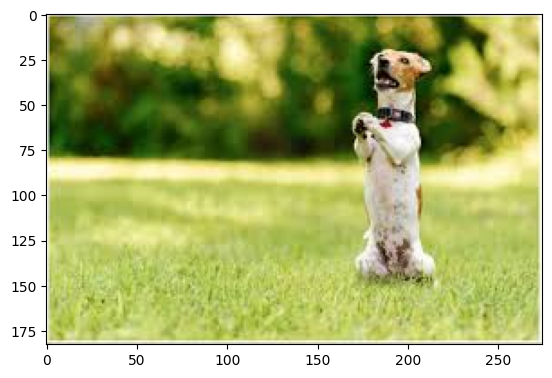

In [8]:
image_file_path = '/content/images (1).jpeg'


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def load_image(image_file_path, transform=None):
    img = Image.open(image_file_path).convert('RGB')
    img = img.resize([224, 224], Image.LANCZOS)

    if transform is not None:
        img = transform(img).unsqueeze(0)

    return img


# Image preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))])


# Load vocabulary wrapper
with open('/content/vocabulary.pkl', 'rb') as f:
    vocabulary = pickle.load(f)


# Build models
encoder_model = CNNModel(256).eval()  # eval mode (batchnorm uses moving mean/variance)
decoder_model = LSTMModel(256, 512, len(vocabulary), 1)
encoder_model = encoder_model.to(device)
decoder_model = decoder_model.to(device)


# Load the trained model parameters
encoder_model.load_state_dict(torch.load('/content/encoder-9-200.ckpt', map_location=torch.device('cpu')))
decoder_model.load_state_dict(torch.load('/content/decoder-9-200.ckpt', map_location=torch.device('cpu')))


# Prepare an image
img = load_image(image_file_path, transform)
img_tensor = img.to(device)


# Generate an caption from the image
feat = encoder_model(img_tensor)
sampled_indices = decoder_model.sample(feat)
sampled_indices = sampled_indices[0].cpu().numpy()  # (1, max_seq_length) -> (max_seq_length)


# Convert word_ids to words
predicted_caption = []
for token_index in sampled_indices:
    word = vocabulary.i2w[token_index]
    predicted_caption.append(word)
    if word == '<end>':
        break
predicted_sentence = ' '.join(predicted_caption)


# Print out the image and the generated caption
print (predicted_sentence)
img = Image.open(image_file_path)
plt.imshow(np.asarray(img))